In [1]:
import torch
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn # 인공 신경망 모델들 모아놓은 모듈
import torch.nn.functional as F #그중 자주 쓰이는것들을 F로
from torchvision import transforms, datasets
import cv2
import pandas as pd
import os
from glob import glob
import torchvision.models as models
import sys
import librosa, librosa.display 

p = os.path.abspath('D:/project/voice_pathology_ai/model') # 상위 폴더를 사용하기 위해서.
sys.path.insert(1, p)
from pytorchtools.pytorchtools import EarlyStopping # 상위 폴더에 추가된 모듈.


if torch.cuda.is_available():
    DEVICE = torch.device('cuda')
else:
    DEVICE = torch.device('cpu')
#DEVICE = torch.device('cpu')
print('Using Pytorch version : ',torch.__version__,' Device : ',DEVICE)

Using Pytorch version :  1.10.2  Device :  cuda


In [2]:
import torchaudio
import torchaudio.transforms as T

In [3]:
#1. train, test 나누기

import os
from glob import glob
from sklearn.model_selection import StratifiedKFold
from imblearn.over_sampling import RandomOverSampler
from collections import Counter
from sklearn.model_selection import train_test_split # train , test 분리에 사용.


pathology = glob('D:/project/voice_pathology_ai/voice_data/all_data/pathology/phrase/*.wav')
healthy = glob('D:/project/voice_pathology_ai/voice_data/all_data/healthy/phrase/*.wav')
print("Pathology : ",len(pathology))
print("Healthy: ",len(healthy))

pathology= [ path.split("\\")[-1] for path in pathology] # path 데이터 변환.
healthy= [ path.split("\\")[-1] for path in healthy] # path 데이터 변환.
 # path 데이터 변환 #외부데이터로 가져오기위해서, 번호만 남긴다

    
X = pathology+healthy # path 데이터 합
print("총 데이터수 : ",len(X))
Y = [] # 라벨
for idx,x in enumerate(X):
    if idx<1354:
        Y.append("pathology")
    else:
        Y.append("healthy")

X, X_test, Y, Y_test = train_test_split(X, Y, test_size=0.2, shuffle=True, stratify=Y, random_state=456)
#stratify를 넣어서, test에도 라벨별 잘 분류되게 한다.

print("---")
print("훈련 셋 : ",len(Y),Counter(Y))
print("테스트 셋 : ",len(Y_test),Counter(Y_test))
print("---")

Pathology :  1354
Healthy:  634
총 데이터수 :  1988
---
훈련 셋 :  1590 Counter({'pathology': 1083, 'healthy': 507})
테스트 셋 :  398 Counter({'pathology': 271, 'healthy': 127})
---


In [4]:
import pickle

 
#load
with open("D:/project/voice_pathology_ai/voice_data/all_data/phrase_sig_dict.pickle","rb") as fr:
    phrase_dict = pickle.load(fr)

    

In [6]:
Y

['pathology',
 'pathology',
 'pathology',
 'pathology',
 'pathology',
 'pathology',
 'healthy',
 'pathology',
 'pathology',
 'pathology',
 'pathology',
 'pathology',
 'pathology',
 'healthy',
 'pathology',
 'pathology',
 'healthy',
 'pathology',
 'pathology',
 'pathology',
 'pathology',
 'healthy',
 'pathology',
 'pathology',
 'pathology',
 'pathology',
 'pathology',
 'pathology',
 'pathology',
 'pathology',
 'pathology',
 'healthy',
 'pathology',
 'pathology',
 'pathology',
 'pathology',
 'pathology',
 'healthy',
 'healthy',
 'pathology',
 'pathology',
 'healthy',
 'healthy',
 'pathology',
 'pathology',
 'healthy',
 'healthy',
 'pathology',
 'pathology',
 'pathology',
 'pathology',
 'pathology',
 'healthy',
 'healthy',
 'pathology',
 'healthy',
 'pathology',
 'healthy',
 'pathology',
 'healthy',
 'healthy',
 'pathology',
 'healthy',
 'pathology',
 'pathology',
 'healthy',
 'pathology',
 'pathology',
 'pathology',
 'pathology',
 'healthy',
 'pathology',
 'pathology',
 'healthy',
 'path

In [11]:
sr=16000
win_length =  np.int64(sr/40) # 
n_fft= win_length # WINDOWS SIZE중 사용할 길이. WINDOW SIZE가 넘어가면 나머지 것들은 zero padding
hop_length= np.int64( np.ceil(win_length/4) ) #  얼마만큼 시간 주기(sample)를 이동하면서 분석을 할 것인지. 일반적으로 window size의 1/4
#또는 10ms만큼으로 한다고 한다.
#hop_length가 mfcc의 frame수를 결정한다.


feature_lists = []

for x in X:
    sig =  phrase_dict[x] # 16000hz 실시
    mel_feature = librosa.feature.melspectrogram(y=sig, sr=sr, hop_length=hop_length, n_fft=n_fft)
    mel_feature = mel_feature.mean(axis=1)
    feature_lists.append(mel_feature)
    

    

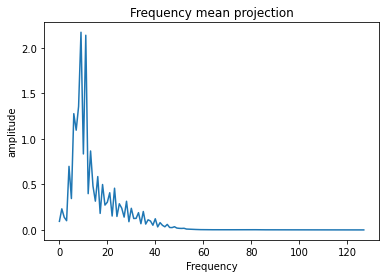

In [33]:
all_mean=np.array(feature_lists).mean(axis=0)


plt.plot(all_mean)
plt.xlabel('Frequency')
plt.ylabel('amplitude')
plt.title('Frequency mean projection')
plt.show()




주로 0~50에서 발생한다.
이미지 사이즈를 50으로 줄여도 무관해 보인다.

In [37]:
sr=16000
win_length =  np.int64(sr/40) # 
n_fft= win_length # WINDOWS SIZE중 사용할 길이. WINDOW SIZE가 넘어가면 나머지 것들은 zero padding
hop_length= np.int64( np.ceil(win_length/4) ) #  얼마만큼 시간 주기(sample)를 이동하면서 분석을 할 것인지. 일반적으로 window size의 1/4
#또는 10ms만큼으로 한다고 한다.
#hop_length가 mfcc의 frame수를 결정한다.


feature_lists_pathology = []
feature_lists_healthy = []


for idx,y in enumerate(Y):
    if y=='healthy':
        x=X[idx]
        sig =  phrase_dict[x] # 16000hz 실시
        mel_feature = librosa.feature.melspectrogram(y=sig, sr=sr, hop_length=hop_length, n_fft=n_fft)
        mel_feature = mel_feature.mean(axis=1)
        feature_lists_healthy.append(mel_feature)
    else:
        x=X[idx]
        sig =  phrase_dict[x] # 16000hz 실시
        mel_feature = librosa.feature.melspectrogram(y=sig, sr=sr, hop_length=hop_length, n_fft=n_fft)
        mel_feature = mel_feature.mean(axis=1)
        feature_lists_pathology.append(mel_feature)        
    

    

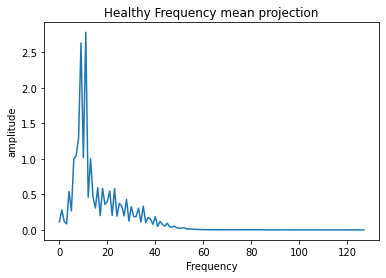

In [38]:
healthy_mean=np.array(feature_lists_healthy).mean(axis=0)


plt.plot(healthy_mean)
plt.xlabel('Frequency')
plt.ylabel('amplitude')
plt.title('Healthy Frequency mean projection')
plt.show()




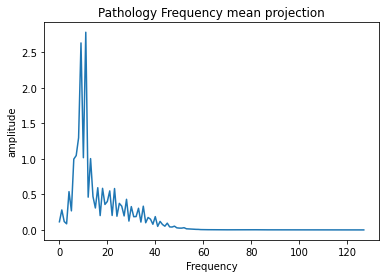

In [41]:
pathology_mean=np.array(feature_lists_healthy).mean(axis=0)


plt.plot(pathology_mean)
plt.xlabel('Frequency')
plt.ylabel('amplitude')
plt.title('Pathology Frequency mean projection')
plt.show()


